### Library Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from shapely import geometry
import geopandas
import shapely.wkt

# pd.options.display.max_colwidth = 100000

### Read in Data

In [23]:
# Read FIR Codes
df = pd.read_csv('data/NA_FIR_Codes.csv')

# Read Vertices
df2 = pd.read_csv('data/vertices_20220621.csv')

# Read Spaceports
df3 = pd.read_csv ('data/spaceports_20201027.csv')

# Read pickle file with topics and augmented text
df4 = pd.read_pickle("data/allData.pkl")

# Read Polygon File
df5 = pd.read_csv('data/polygon_20201027.csv')

# Read in launch data
df6 = pd.read_csv('data/launches_20201027.csv', parse_dates=['LAUNCH_DATE'])

# Read Basemap Shapefile
states = geopandas.read_file('data/bound_p.shx')

### Helper Functions

#### Facet Filter Function
Applies all our filters to each row of a dataframe

In [3]:
# Processing function
def getNotams(time, launch_id):
    # Date filter
    filterA = df4[(df4['POSSIBLE_START_DATE'] <= time) & (df4['POSSIBLE_END_DATE'] >= time)]
    
    # Altitude filter
    filterB = filterA[filterA['MAX_ALT'] >= 50000 | filterA['MAX_ALT'].isna()]
    
    # FIR Code filter
    filterC = filterB[filterB['LOCATION_CODE'].isin(df['FIR']) | filterB['LOCATION_CODE'].isna()]
    
    # Keyword filter
    filterD = filterC[(filterC['TEXT'].str.contains(r'(?:\s|^)rocket(?:\s|$)') == True) | 
                      (filterC['TEXT'].str.contains(r'(?:\s|^)space(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)launch(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)missile(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)canaveral(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)kennedy(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)nasa(?:\s|$)') == True) |
                      (filterC['TEXT'].str.contains(r'(?:\s|^)unlimited(?:\s|$)') == True)]
    
    # Topic filter
    filterE = filterD[(filterD['TOPIC'] == 0) | (filterD['TOPIC'] == 7)]
    
    # Get IDs for Candidate NOTAMs
    id_list, rec_ids = getIds(filterE, df5)

    # Get Polygons for Candidate NOTAMs
    P = getPolygons(id_list)
    
    test2 = pd.DataFrame(P, index=['boundary']).rename_axis('polygon_id', axis=1).transpose().reset_index()

    if id_list == []:
        if len(filterE['NOTAM_REC_ID'] > 0):
            return filterE['NOTAM_REC_ID'].tolist()
        else:
            return
    
    interactions_df = find_interactions(sp_df_2, test2,
                                        ['SPACEPORT_REC_ID'], ['polygon_id'],
                                        'buffer', 'boundary')

    interactions_df['NOTAM_REC_ID'] = [rec_ids[x] for x in interactions_df['polygon_id']]
    
    filterF = filterE[(filterE['NOTAM_REC_ID'].isin(interactions_df[interactions_df['SPACEPORT_REC_ID'] == launch_id]['NOTAM_REC_ID'].unique()))]
    
    if len(filterF['NOTAM_REC_ID'] > 0):
        return filterF['NOTAM_REC_ID'].tolist()
    else:
        return

#### Get Polygon Ids and Polygon Geometries

In [4]:
# Creates WKT Polygons
def getPolygons(id_list):
    all_polys = {}

    for poly_id in id_list:
        tmp = df2[df2['POLYGON_ID'] == poly_id]

        long = tmp['LONGITUDE'].astype(str).values
        lat = tmp['LATITUDE'].astype(str).values

        pointList = list(zip(tmp['LONGITUDE'], tmp['LATITUDE']))

        if len(pointList) == 1:
            poly = geometry.Point([pointList[0][0], pointList[0][1]])
        elif len(pointList) == 2:
            poly = geometry.LineString([[p[0], p[1]] for p in pointList])
        else:
            poly = geometry.Polygon([[p[0], p[1]] for p in pointList])

        all_polys[poly_id] = poly
        
    return all_polys

# Gets Poylgon ID from NOTAM ID
def getIds(rec_ids, poly_df):
    id_list = []
    rec_id = {}
    for row in rec_ids['NOTAM_REC_ID']:
        for item in poly_df[poly_df['NOTAM_REC_ID'] == row]['POLYGON_ID'].values:
            id_list.append(item)
            rec_id[item] = row
            
    return id_list, rec_id

#### Geocircle and Conversion Functions

In [5]:
#This is a utility function for converting distance values using different units
def conv_dist(distance_value, units_value):
    # Determine the conversion factor for the specified units (meters are required for this projection)
    if units_value == "mi":
        unit_factor = 1609.344
    elif units_value == "km":
        unit_factor = 1000.0
    elif units_value == "ft":
        unit_factor = 0.3048
    elif units_value == "nm":
        unit_factor = 1852
    elif units_value == "m":
        unit_factor = 1
    else:  # Bad units
        unit_factor = 0

    return distance_value * unit_factor

#This function creates geospatial circle(s) based on center, radius and unit values in the dataset
def gen_geocircle(input_df, key_col, center_col, radius_col, units_col):

    # Convert point data to geopandas dataframe
    working_cols = [key_col] + [center_col] + [radius_col] + [units_col]
    return_cols = [key_col] + ["buffer"]
    
    pointsdf = input_df[working_cols]
    gdf_pts = geopandas.GeoDataFrame(pointsdf, geometry=center_col)
    
    # Add CRS (start with WGS84 to match lat/lon values)
    gdf_pts.set_crs(epsg=4326, inplace=True)

    #Prepare projection (North America Lambert Conformal Conic)
    # This projection is equidistant for measuring between points.
    # Units are in meters
    projout = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs'

    # Convert to Lambert projection
    gdf_pts = gdf_pts.to_crs(projout)
    gdf_pts[units_col] = gdf_pts[units_col].str.lower()
    gdf_pts["dist"] = 0

    for pt_index,pt_row in gdf_pts.iterrows():
        dvalue = conv_dist(pt_row[2], pt_row[3])

        gdf_pts.loc[pt_index,'dist'] = dvalue

    gdf_pts["buffer"] = gdf_pts[center_col].buffer(gdf_pts['dist'])

    gdf_circle = gdf_pts[return_cols]

    gdf_circle = geopandas.GeoDataFrame(gdf_circle, geometry='buffer')

    gdf_circle = gdf_circle.to_crs(epsg=4326)

    
    return gdf_circle

#### Interactions Function

In [6]:
#This function determines takes two sets of geospatial objects and determines which ones interact
def find_interactions(geom_set1_df, geom_set2_df,
                      set1_key_cols, set2_key_cols,
                      set1_geometry_col, set2_geometry_col
                      ):

    set1_working_cols = set1_key_cols + [set1_geometry_col]
    set2_working_cols = set2_key_cols + [set2_geometry_col]
    
    # Convert point data to geopandas dataframe

    gdf1 = geom_set1_df[set1_working_cols]
    gdf1 = geopandas.GeoDataFrame(gdf1, geometry=set1_geometry_col)

    # Add CRS (start with WGS84 to match lat/lon values)
    gdf1.set_crs(epsg=4326, inplace=True)
    gdf1_type = gdf1.loc[0, set1_geometry_col].geom_type

    #Convert polygon data to geopandas dataframe
    gdf2 = geom_set2_df[set2_working_cols]
    gdf2 = geopandas.GeoDataFrame(gdf2, geometry=set2_geometry_col)

    # Add CRS (start with WGS84 to match lat/lon values)
    gdf2.set_crs(epsg=4326, inplace=True)
    gdf2_type = gdf2.loc[0, set2_geometry_col].geom_type

    #If datasets are mixed (one polygon and one linestring), ensure polygons are gdf1
    if (gdf1_type == 'LineString' or gdf1_type == 'Point') and gdf2_type == 'Polygon':
        gdf_temp = gdf1
        gdf1 = gdf2
        gdf2 = gdf_temp
        gdf2_type = gdf1_type
        gdf1_type = 'Polygon'
        keys_temp = set1_key_cols
        set1_key_cols = set2_key_cols
        set2_key_cols = keys_temp
        geom_temp = set1_geometry_col
        set1_geometry_col = set2_geometry_col
        set2_geometry_col = geom_temp
        
    # Convert to new equidistant projection

    #Prepare projection (North America Lambert Conformal Conic)
    # This projection is equidistant for measuring between points.
    # Units are in meters
    projout = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs'

    # Convert to Lambert projection
    gdf1 = gdf1.to_crs(projout)

    # Convert to Lambert projection
    gdf2 = gdf2.to_crs(projout)

    results = pd.DataFrame(columns=(set1_key_cols + set2_key_cols + ['Interaction']))
    
    df_index = 0
    
    for gdf1_index,gdf1_row in gdf1.iterrows():
        for gdf2_index,gdf2_row in gdf2.iterrows():
            if gdf1_type == 'Polygon' and gdf2_type == 'LineString':
                interaction = gdf1.loc[gdf1_index, set1_geometry_col].intersects(gdf2.loc[gdf2_index, set2_geometry_col])
                if interaction:
                    start_pt, end_pt = gdf2.loc[gdf2_index, set2_geometry_col].boundary
                    if gdf1.loc[gdf1_index, set1_geometry_col].contains(gdf2.loc[gdf2_index, set2_geometry_col]):
                        interact_str = ['Contains']
                    elif gdf1.loc[gdf1_index, set1_geometry_col].contains(start_pt):
                        interact_str = ['Start']
                    elif gdf1.loc[gdf1_index, set1_geometry_col].contains(end_pt):
                        interact_str = ['End']
                    else:
                        interact_str = ['Intersect']

                    results.loc[df_index] = np.concatenate((gdf1.loc[gdf1_index, set1_key_cols].values,
                                            gdf2.loc[gdf2_index, set2_key_cols].values,
                                            interact_str),axis=None)
                    df_index += 1
            elif gdf1_type == 'LineString' and gdf2_type == 'LineString':
                interaction = gdf1.loc[gdf1_index, set1_geometry_col].intersects(gdf2.loc[gdf2_index, set2_geometry_col])
                if interaction:
                    interact_str = ['Intersect']

                    results.loc[df_index] = np.concatenate((gdf1.loc[gdf1_index, set1_key_cols].values,
                                            gdf2.loc[gdf2_index, set2_key_cols].values,
                                            interact_str),axis=None)
                    df_index += 1
            elif gdf1_type == 'Polygon' and gdf2_type == 'Polygon':
                interaction = gdf1.loc[gdf1_index, set1_geometry_col].intersects(gdf2.loc[gdf2_index, set2_geometry_col])
                if interaction:
                    if gdf1.loc[gdf1_index, set1_geometry_col].contains(gdf2.loc[gdf2_index, set2_geometry_col]):
                        interact_str = ['Contains']
                    else:
                        interact_str = ['Intersect']

                    results.loc[df_index] = np.concatenate((gdf1.loc[gdf1_index, set1_key_cols].values,
                                            gdf2.loc[gdf2_index, set2_key_cols].values,
                                            interact_str),axis=None)
                    df_index += 1
            elif gdf1_type == 'Polygon' and gdf2_type == 'Point':            
                if gdf2.loc[gdf2_index, set2_geometry_col].within(gdf1.loc[gdf1_index, set1_geometry_col]):
                    results.loc[df_index] = np.concatenate((gdf1.loc[gdf1_index, set1_key_cols].values,
                                                            gdf2.loc[gdf2_index, set2_key_cols].values,
                                                            "Contained"),axis=None)
                    df_index += 1

            else:
                print('no match')
                
                
    return results

In [7]:
#Convert the latitude/longtitude values to geospatial points
spaceport_df = df3

spaceport_df['FacilityLocation'] = [geometry.Point(xy) for xy in zip(spaceport_df['LONGITUDE'], spaceport_df['LATITUDE'])]

spaceport_df['radius'] = 100
spaceport_df['units'] = 'nm'

spaceport_df = spaceport_df[spaceport_df['SPACEPORT_REC_ID'] > 1]

sp_df_2 = gen_geocircle(spaceport_df, 'SPACEPORT_REC_ID', 'FacilityLocation', 'radius', 'units')

### Manual Testing

In [8]:
# One off testing and tuning

#time = '10/05/2017  08:00:00 AM' #349
#time = '2/20/2016  7:40:00 PM' #230
#time = '4/22/2020  7:30:30 PM' #514
#time = '4/2/2018  8:30:38 PM' #391
#time = '11/16/2017  2:52:00 AM' #364
#time = '12/5/2018  6:16:16 PM' #438
#time = '10/17/2018  4:15:00 AM' #431 has JAXA launch in it as well (t=6)
#time = '9/24/2017  5:49:47 AM' #347
#time = '8/6/2019  11:23:00 PM' #475 has a russian launch as well (t=6)
#time = '3/26/2020  8:18:00 PM' #512
#time = '3/18/2017  11:44:00 PM' #305
#time = '8/16/2016  11:31:00 PM' #262
#time = '5/26/2016  9:40:00 PM' #248
#time = '2/22/2018  2:17:00 PM' #385
#time = '3/2/2019  12:00:00 AM' #450
#time = '11/11/2016  6:30:33 PM' #275
#time = '10/30/2017  7:34:00 PM' #358
#time = '10/30/2017  12:57:00 AM' #357
#time = '1/27/2020  1:40:00 AM' #504
time = '1/31/2018  9:25:00 PM' #383
launch_id = 2

date_time_obj = datetime.strptime(time, '%m/%d/%Y %H:%M:%S %p')

In [9]:
# Date filter
filterA = df4[(df4['POSSIBLE_START_DATE'] <= time) & (df4['POSSIBLE_END_DATE'] >= time)]

In [10]:
# Altitude filter
filterB = filterA[filterA['MAX_ALT'] >= 50000 | filterA['MAX_ALT'].isna()]

In [11]:
# Keyword filter
filterC = filterB[(filterB['TEXT'].str.contains(r'(?:\s|^)rocket(?:\s|$)') == True) | 
                      (filterB['TEXT'].str.contains(r'(?:\s|^)space(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)launch(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)missile(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)canaveral(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)kennedy(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)nasa(?:\s|$)') == True) |
                      (filterB['TEXT'].str.contains(r'(?:\s|^)unlimited(?:\s|$)') == True)]

In [12]:
# FIR Code filter
filterD = filterC[filterC['LOCATION_CODE'].isin(df['FIR']) | filterC['LOCATION_CODE'].isna()]

In [13]:
# Topic filter
filterE = filterD[(filterD['TOPIC'] == 0) | (filterD['TOPIC'] == 7)]

In [14]:
# Geo Filter
# Get IDs for Candidate NOTAMs
id_list, rec_ids = getIds(filterE, df5)

# Get Polygons for Candidate NOTAMs
P = getPolygons(id_list)

test2 = pd.DataFrame(P, index=['boundary']).rename_axis('polygon_id', axis=1).transpose().reset_index()

sp_df_2.reset_index(inplace=True)

interactions_df = find_interactions(sp_df_2, test2,
                      ['SPACEPORT_REC_ID'], ['polygon_id'],
                      'buffer', 'boundary'
                      )

interactions_df['NOTAM_REC_ID'] = [rec_ids[x] for x in interactions_df['polygon_id']]

filterF = filterE[(filterE['NOTAM_REC_ID'].isin(interactions_df[interactions_df['SPACEPORT_REC_ID'] == launch_id]['NOTAM_REC_ID'].unique()))]

In [15]:
# Print out
filterF[['TOPIC', 'XGB','NOTAM_REC_ID', 'TEXT']]

,TOPIC,XGB,NOTAM_REC_ID,TEXT
759235,7,1,759643,erop cross attention airline dispatchers some ...
759236,7,1,759644,airspace stationary altitude reservation cape ...
759264,7,1,759672,flight level airspace kennedy space center fli...
759265,7,1,759673,flight level airspace kennedy space center fli...
759285,7,1,759693,airspace kennedy space center flight level tem...
759286,7,0,759694,temporary flight restrictions kennedy space ce...
759338,7,1,759746,erop cross attention airline dispatchers some ...
767523,0,1,767937,airspace restricted area (followed by identifi...
767524,0,1,767938,airspace restricted area (followed by identifi...


### Apply Facet Filter to All NOTAMs

In [16]:
# Make predictions for launches
df6['DISCOVERED'] = df6.apply(lambda x: getNotams(x['LAUNCH_DATE'], x['SPACEPORT_REC_ID']), axis=1)

### Print All Matches

In [17]:
# Final list of found launches
df6[~df6['DISCOVERED'].isnull().values]

,LAUNCHES_REC_ID,LAUNCH_DATE,VEHICLE_NAME,PAD_NAME,PAYLOAD,AGENCY,PURPOSE,ORBIT_TYPE,OUTCOME,SPACE_LAUNCH_REPORT_FLAG,GUNTER_FLAG,SPACE_FLIGHT_NOW_FLAG,NOONAN_FLAG,AST_FLAG,WIKIPEDIA_FLAG,JSR_FLAG,SPACEPORT_REC_ID,DISCOVERED
242,243,2016-05-06 05:21:00,Falcon 9 v1.2,SLC-40,JCSat 14,SpaceX,Communications,Geosynchronous,Operational,True,True,True,True,True,True,True,2.0,"[21916, 21917]"
247,248,2016-05-26 21:40:00,Falcon 9 v1.2,SLC-40,Thiacom 8,SpaceX,Communications,Geosynchronous,Scrubbed,False,False,False,True,False,False,False,2.0,"[1006, 1076, 1121, 1140, 1155, 6132, 6133]"
248,249,2016-05-27 21:39:00,Falcon 9 v1.2,SLC-40,Thiacom 8,SpaceX,Communications,Geosynchronous,Operational,True,True,True,True,True,True,True,2.0,"[18656, 18658]"
253,254,2016-06-15 14:29:00,Falcon 9 v1.2,SLC-40,Eutelsat 117 West B,SpaceX,Communications,Geosynchronous,Operational,True,True,True,True,True,True,True,2.0,"[24942, 24943, 29952, 29954]"
256,257,2016-06-24 14:30:00,Atlas 5-551,SLC-41,MUOS 5,US Navy,Communications,Geosynchronous,Operational,True,True,True,True,False,True,True,2.0,"[39421, 39423, 43061, 43062, 48743, 48744]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,512,2020-03-26 20:18:00,Atlas 5-551,SLC-41,AEHF 6,US Military,Communications,Supersynchronous,NaN,True,True,True,False,False,True,False,2.0,"[1608021, 1608022, 1612521, 1612522]"
513,514,2020-04-22 19:30:30,Falcon 9 v1.2,LC-39A,Starlink 1 F6,SpaceX,Communications,Low Earth,Operational,True,True,True,False,True,True,False,8.0,"[1629217, 1629218]"
514,515,2020-05-17 13:14:00,Atlas 5-501,SLC-41,USSF 7 (X37B OTV6),US Military,Testing,Low Earth,Operational,True,True,True,False,False,True,False,2.0,"[1634799, 1634800, 1634871, 1634872, 1634873, ..."
515,516,2020-05-25 18:50:00,LauncherOne,NaN,Starshine 4/Flight 1,Virgin Orbit,Testing,Low Earth,Failure,False,True,True,False,True,True,False,11.0,[1641222]


In [18]:
df6[df6['LAUNCHES_REC_ID'] == 383]

,LAUNCHES_REC_ID,LAUNCH_DATE,VEHICLE_NAME,PAD_NAME,PAYLOAD,AGENCY,PURPOSE,ORBIT_TYPE,OUTCOME,SPACE_LAUNCH_REPORT_FLAG,GUNTER_FLAG,SPACE_FLIGHT_NOW_FLAG,NOONAN_FLAG,AST_FLAG,WIKIPEDIA_FLAG,JSR_FLAG,SPACEPORT_REC_ID,DISCOVERED
382,383,2018-01-31 21:25:00,Falcon 9 v1.2,SLC-40,Govsat 1,SpaceX,Communications,Geosynchronous,Operational,True,True,True,True,True,True,True,2.0,"[759643, 759644, 759672, 759673, 759693, 75969..."


### Checking for Duplicates

In [19]:
all_matched = []
for row in df6[['LAUNCH_DATE', 'SPACEPORT_REC_ID']].values:
    tmp = getNotams(row[0], row[1])
    
    if tmp != None:
        all_matched = all_matched + tmp

In [20]:
import collections
dups = [item for item, count in collections.Counter(all_matched).items() if count > 1]
print(dups)

[607593, 607594]


### Print Sample Matched NOTAMs

Text(0.5, 1.0, 'NOTAM Geometries')

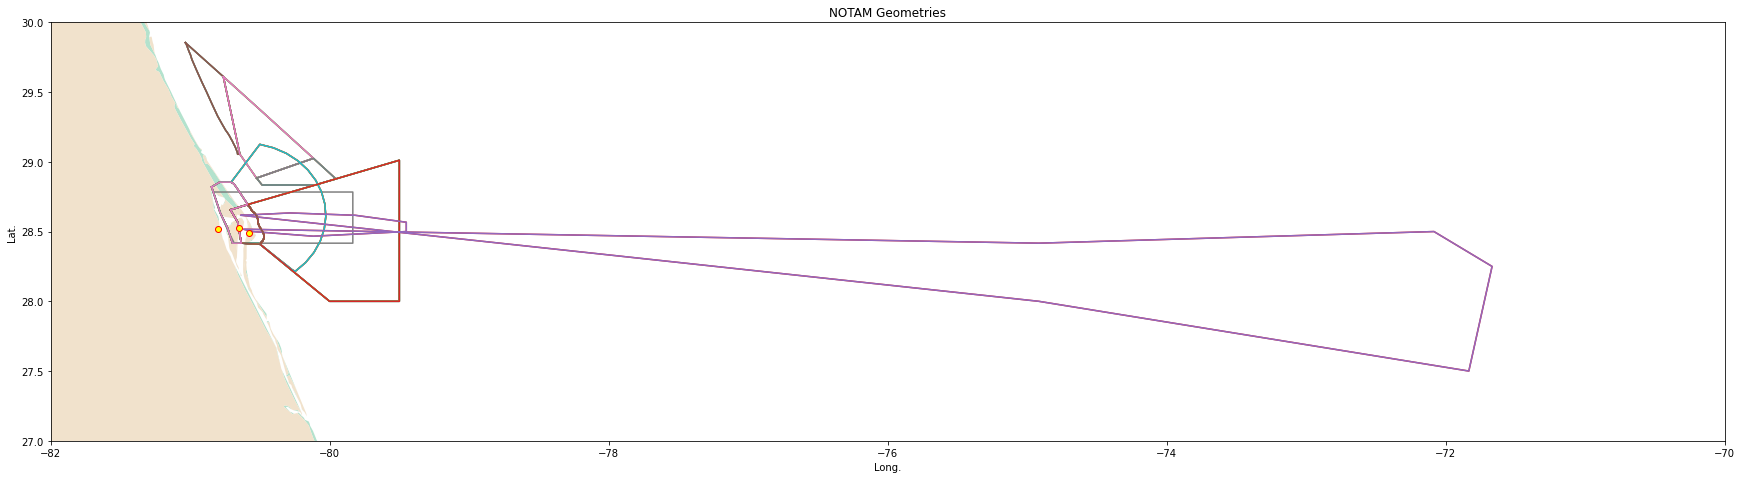

In [28]:
import matplotlib.pyplot as plt
# Get IDs for Candidate NOTAMs
id_list, rec_ids = getIds(filterF, df5)

# Get Polygons for Candidate NOTAMs
P = getPolygons(id_list)

# Plot Base Map
states.plot(cmap='Pastel2', figsize=(30, 10))

# Plot NOTAM Polygons
for item in P.values():
    #if P:
     #   continue
    if item.geom_type != 'Polygon':
        plt.plot(*item.xy)
    else:
        x,y = item.exterior.xy
        plt.plot(x,y)

# ARTCC
#P2 = [shapely.wkt.loads(h) for h in df7['boundary']]
#
#for item in P2:
#    x,y = item.exterior.xy
#    plt.plot(x,y, linestyle="dashdot")
        
# Plot Spaceport Locations
plt.plot(df3['LONGITUDE'], df3['LATITUDE'], marker="o", markeredgecolor="red", markerfacecolor="yellow", linestyle="None")

# Set Zoom
#plt.axis([-83, -78, 27, 30])
#plt.axis([-115, -70, 20, 40])
plt.axis([-82, -70, 27, 30])
plt.ylabel('Lat.')
plt.xlabel('Long.')
plt.title('NOTAM Geometries')